https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb?fbclid=IwAR281p1l2OGGdcpxDDMT2w3KAS1pX-yYQ4tzi5MkR8xRzUAtlfm5dvdIcxM

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [3]:
image = cv2.cvtColor(cv2.imread('/workspace/gvData/segSamps/gv_seg/20220605231413_000097_Trim_frame2.jpg'), cv2.COLOR_BGR2RGB)

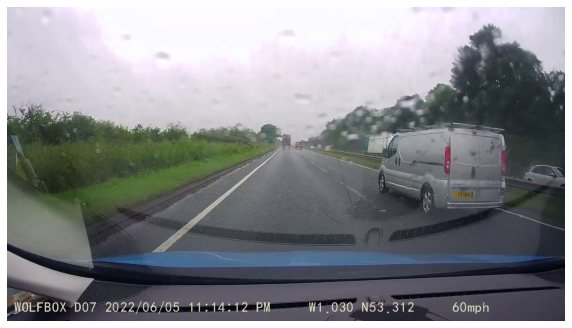

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
import sys

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/workspace/SAM_model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
#produce image embedding
predictor.set_image(image)

In [7]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

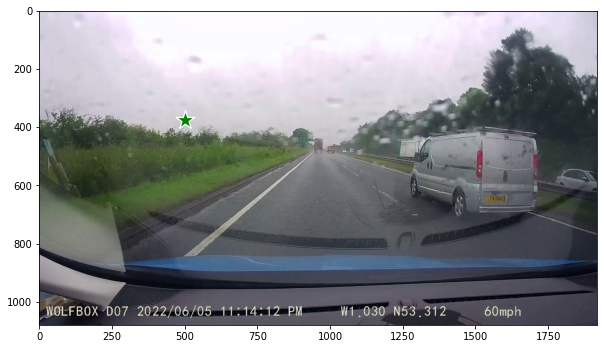

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [9]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [10]:
masks.shape  # (number_of_masks) x H x W

(3, 1080, 1920)

With multimask_output=True (the default setting), SAM outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use multimask_output=True even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

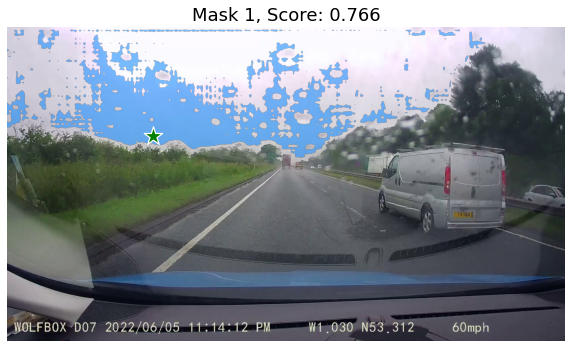

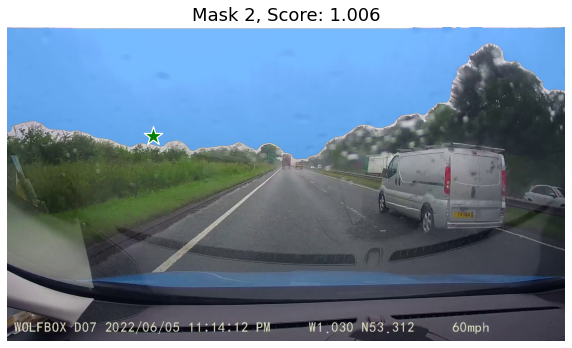

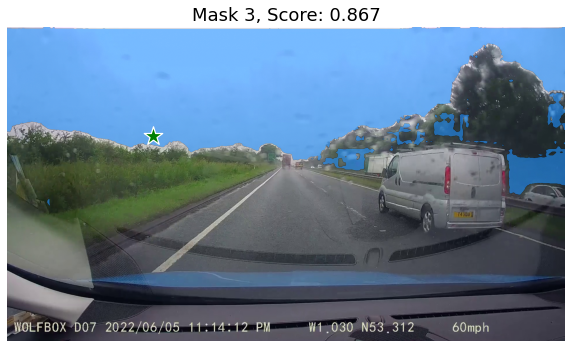

In [11]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

Additional Points:

In [12]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [13]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [14]:
masks.shape

(1, 1080, 1920)

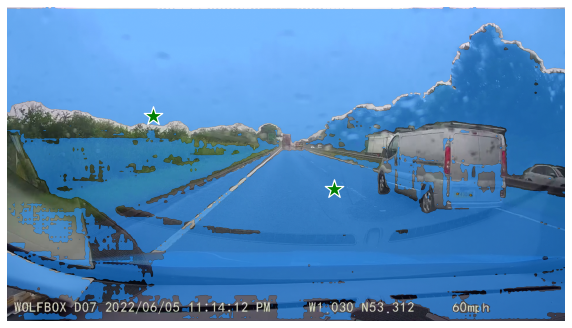

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

Now use set points

In [16]:
import os
import pandas as pd
#get seeds from litter locations
labelCSV = r"/workspace/gvData/segSamps/Training02.csv"

centx = []
centy = []

#annotations file
df_antt = pd.read_csv(labelCSV)

xmin = df_antt["xmin"].values
ymin = df_antt["ymin"].values
xmax = df_antt["xmax"].values
ymax = df_antt["ymax"].values
width = df_antt["width"].values #width and height of IMAGES
height = df_antt["height"].values

for i, name in enumerate(xmin):
    xcen = float((xmin[i] + xmax[i])) / 2 / width[i] #normalise bboxes for yolo according to image size (YOLO is in format <class> <x centroid> <y centroid> <bb width> <bb height>)
    ycen = float((ymin[i] + ymax[i])) / 2 / height[i]
    
    centx.append(xcen)
    centy.append(ycen)

In [17]:
#Set points to image-size
newCentx = np.multiply(centx, 1920)
newCenty = np.multiply(centy, 1080)

#perform kmeans
from sklearn.cluster import KMeans
import numpy as np
#unnormalised
points = [(newCentx[i], newCenty[i]) for i in range(0, len(centx))]

kmeans = KMeans(n_clusters=15, random_state=0).fit(points)


kCents = kmeans.cluster_centers_
x,y = zip(*kCents)

In [18]:
print(x,y)

(429.6941438574158, 1603.9649532710282, 203.45330296127554, 704.6089108910892, 1784.0860366713691, 1226.3298076923074, 552.25, 286.13126252505, 569.3289017341041, 115.22597137014287, 88.96242774566463, 259.5922330097088, 324.1397652237712, 1424.962660443407, 425.4596858638744) (580.7186505410567, 706.2669392523364, 629.7680334092635, 572.2167216721673, 738.3392101551481, 599.7490384615385, 552.3353448275861, 536.317134268537, 678.4404624277456, 545.3788343558282, 702.9693641618497, 769.0582524271845, 644.8738077769626, 663.3208868144691, 733.2523560209424)


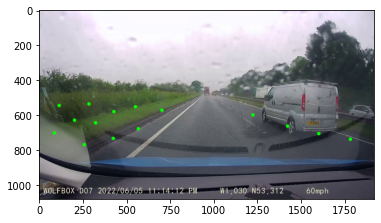

In [19]:
#plot clustered points
plotted_im = image.copy()
for i in range(0,len(x)):
    cv2.circle(plotted_im, (int(x[i]),int(y[i])), radius=10, color=(0, 255, 0), thickness=-1)
    
plt.imshow(plotted_im)

In [20]:
input_point = np.array([[i,j] for i,j in zip(x,y)])
input_label = np.array([1]*len(x))

In [21]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=True,
)

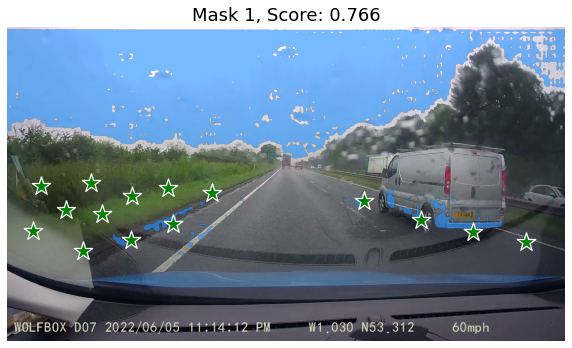

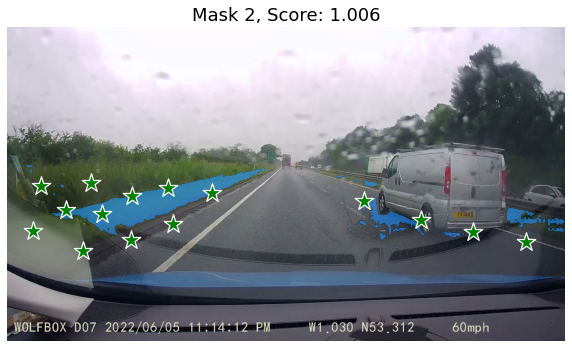

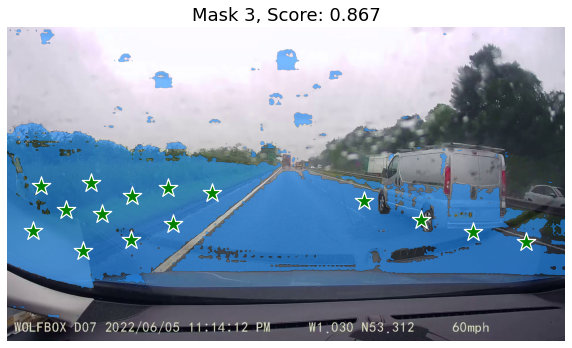

In [22]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [23]:
#Try Slicing image in half

(1080, 960, 3)


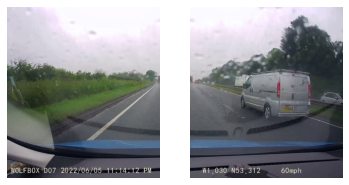

In [24]:
slice1 = image[:,:1920//2,:]
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(slice1)
print(slice1.shape)

plt.subplot(1,2,2)
plt.axis('off')
slice2 = image[:,1920//2:,:]
plt.imshow(slice2)

In [25]:
leftpoints = [x for x in input_point if x[0] < (1920//2) ]

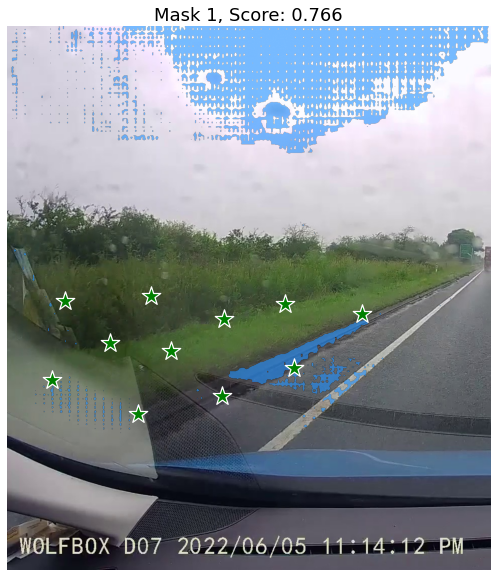

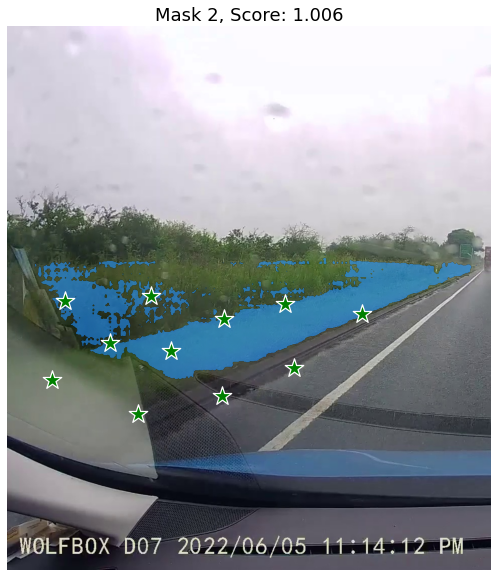

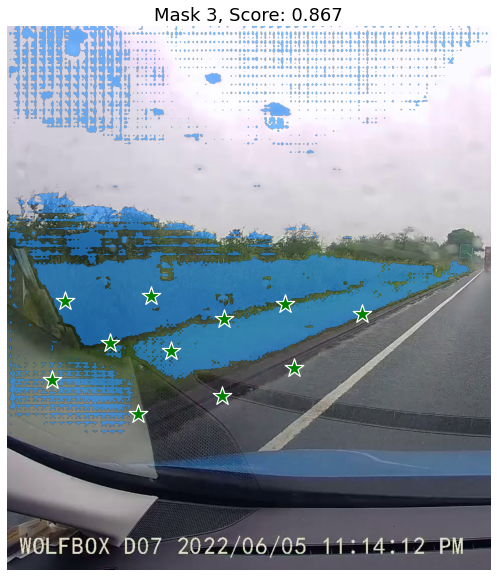

In [26]:
#Left Side of Image

#produce image embedding
predictor.set_image(slice1)

left_label = np.array([1]*len(leftpoints))
leftpoints = np.array(leftpoints)


leftMasks, _, _ = predictor.predict(
    point_coords=leftpoints,
    point_labels=left_label,
    mask_input=mask_input[None, :, :],
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(leftMasks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(slice1)
    show_mask(mask, plt.gca())
    show_points(leftpoints, left_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

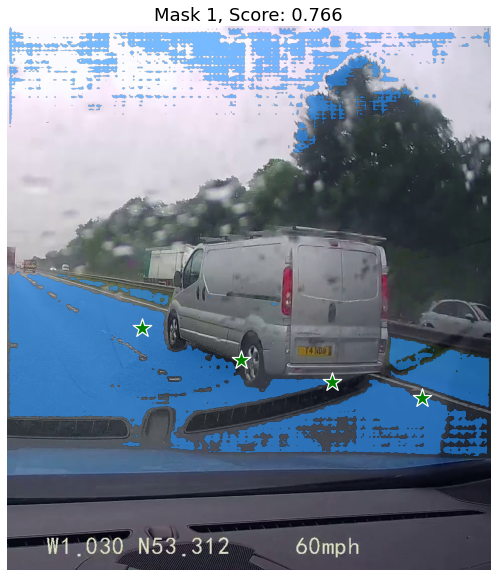

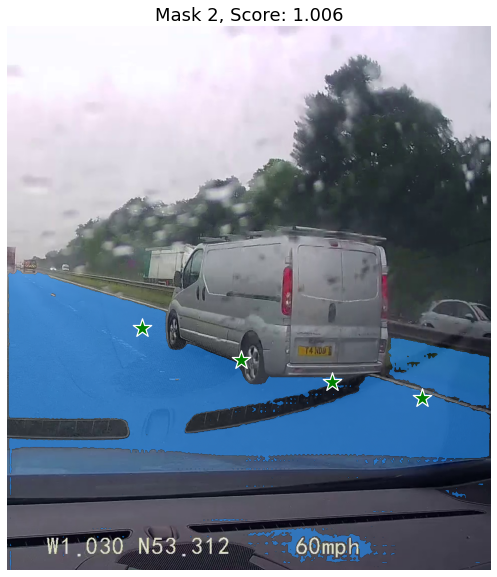

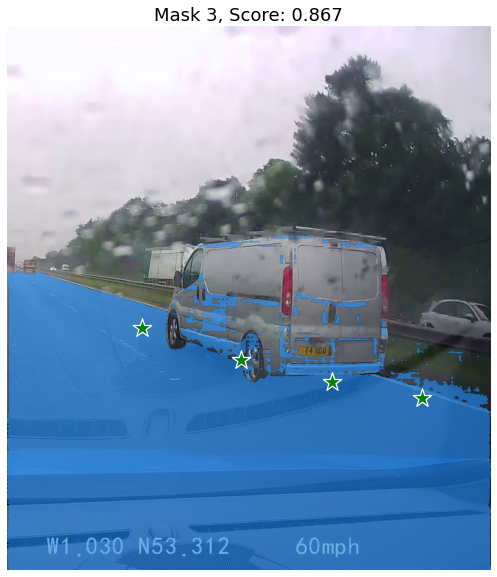

In [27]:
#Right Side of Image
rightpoints = [x for x in input_point if x[0] > (1920//2)]
rightpoints = [[x[0]-(1920//2),x[1]] for x in rightpoints]

#produce image embedding
predictor.set_image(slice2)

right_label = np.array([1]*len(rightpoints))
rightpoints = np.array(rightpoints)


rightMasks, _, _ = predictor.predict(
    point_coords=rightpoints,
    point_labels=right_label,
    mask_input=mask_input[None, :, :],
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(rightMasks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(slice2)
    show_mask(mask, plt.gca())
    show_points(rightpoints, right_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [28]:
#Fuse Masks and ims
comb_mask = np.hstack((leftMasks[1],rightMasks[1]))
comb_mask.shape

(1080, 1920)

<Figure size 1440x1080 with 0 Axes>

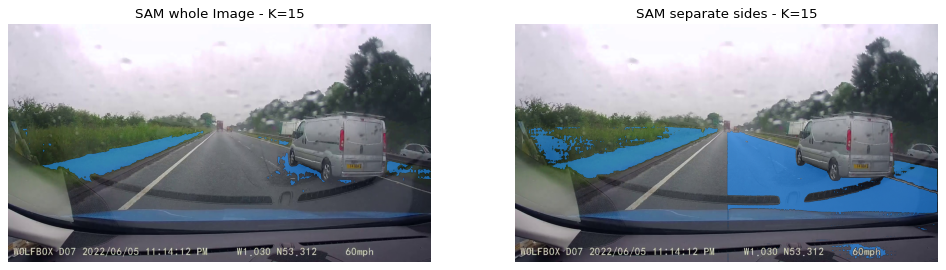

In [29]:
plt.figure(figsize=(20,15))
compare = [masks[1],comb_mask]
ims = [image,image]
ts = ["SAM whole Image - K=15", "SAM separate sides - K=15"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharex=False, sharey=False)
# ax[1].imshow(image1, cmap='gray')
# ax[0].imshow(image2, cmap='gray')

for i in range(0,2):
    #plt.subplot(1,2,i+1)    
    ax[i].imshow(ims[i])
    show_mask(compare[i], ax[i])
    #plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    ax[i].axis('off')
    ax[i].set_title(ts[i])
    fig.show() 

In [30]:
#Try as different classes (Left Verge, Right verge)